# Spend engine
## Objective
Develop code for generating spending projections based on:
- underlying lifecycle profile (launch to patent expiry etc)
- successive cohorts of launches
 
Allow for:
- growth between cohorts
- continuing spend at end of lifecycle
- discontinuous changes - eg one-off multiplication of profile
 
Plot locally for now, but will want to integrate with web app / UI.
 
## Status
- Main function takes a *discontinous* profile (as a `np.array`), timings, growth rates etc.  Can then return spend projections (as pandas `pd.Series`) for a given time period.  
- Basic engine seems to work.  
- Can use any time periods / intervals, but currently won't deal with dates as such (only years *or* months - ie a single time unit)

## Notes
Leaves profile generation to some other functionality.  Could use three approaches to generate the input:
- directly generate the monthly profile
- generate from a continuous function
- generate from a set of user-defined points

## Next up
- currently passes the whole info set to the spender() generator.  Feels inefficient,  but what's alternative?  define the generator in the main function?  Is this really a problem?  [It's much quicker than an object]
- Can at least simplify input eg using a `named_tuple` rather than all those arguments.  Though maybe wait to see what the front end is
- Sort so it can deal with months *and* years  (use pandas date format).  [Remember to divide annual growth rates etc by 12]  
- Options for dumping eg to excel?  Debug output?  
- Actually check the results are right! Excel probably. 
- Write some unit tests  
- Think about any errors might need catching

## Main code

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

### Core spend per period function
Given input profile, timings etc, returns the spend on each cohort.  It's a generator, intended to be consumed as `sum(spender(...))`.

In [9]:
    def spender(spend_per, profile, launch_pers, coh_growth, term_growth, debug=False):
        '''Generator function which iterates through all cohorts extant at spend_per,
        yielding spend adjusted for cohort growth and terminal change.  
        Designed to be consumed with sum(self._spender(spend_per)).
        '''
        prof_len = len(profile)
        term_value = profile[-1]
        
        # NB - USES ZERO-BASED INDEXING FOR EVERYTHING
        
        # First, define the frame by going back from the spend period by the number of launch periods
        # This frame must give the actual indexes of relevant elements of the profile for iterating
        # Zero based, and wants to go one past the end (because that's how iteration works)
        
        frame = (max(0, spend_per - launch_pers), spend_per+1)   
        
            # eg if spend_per is 5 (6 periods) and there are 2 cohorts, then want indices 4-5
            # so frame is (3,6)
        
        f_start, f_end = frame
        last_coh = min(launch_pers, spend_per) # minus 1 to make zero based
        
        if debug:
            print("Frame: ", frame, "   Extant cohorts:  ", last_coh+1)
            titles = "Prof point, Coh id, Raw val, Coh adj, Term adj, Total adj,   Val".split(",")
            pads = [len(t)-1 for t in titles]
            print(" |".join(titles))

        # Iterate through the frame (i.e. through the cohorts), yielding the spend at the
        # corresponding profile point, adjusted as necessary. 
        # If the profile point is beyond the terminal, then calculate appropriately
       
        for i, prof_point in enumerate(range(f_start, f_end)):
            
            # Helps to know which cohort we're on. Last period in  frame corresponds to the 0th cohort.
            # So the first will correspond to the last launch period (minus 1 to make start at zero).  
            # Then iterate through with the index
            coh_id = last_coh - i
            coh_adj = (1+coh_growth)**coh_id # used to adjust for growth between cohorts
            term_adj = 1 # will be used to adjust for change after period - set to 1 initially
            
            if debug: print(str(prof_point).rjust(pads[0]+1), "|", 
                            str(coh_id).rjust(pads[1]), "|", end="") 
                            
           
            # As long as the period is within the profile, yield the corresponding profile point
            if prof_point < prof_len: # length is one past the last index
                val = profile[prof_point] * coh_adj # adjust for cohort growth              

                
            # If the period is beyond the profile, use the terminal value
            else:
                # adjust the terminal value by the cohort growth, then for change after terminal period
                term_adj = (1+term_growth)**(prof_point - prof_len+1)
                val = term_value * coh_adj * term_adj

            if debug: 
                if prof_point < prof_len:
                    raw_val = profile[prof_point]
                    term_adj_str = "-"
                else:
                    raw_val = term_value
                    term_adj_str = "{0:.3f}".format(term_adj)
                    
                print(str(raw_val).rjust(pads[2]), " |", 
                          "{0:.3f}".format(coh_adj).rjust(pads[3]),  "|",
                          term_adj_str.rjust(pads[4]), "|", 
                          "{0:.3f}".format(term_adj*coh_adj).rjust(pads[5]), "|", 
                          "{0:.2f}".format(val).rjust(pads[6])) 
            yield val


### Main function
Returns a projection for a given set of spend and timings, as a `pd.Series`.  Main loop is to call `sum(spender(..))` for each period, and put the results in an `np.array` which is then wrapped in a `pd.Series` and returned.

In [10]:
def get_forecast(profile, l_start, l_stop, proj_stop, 
          coh_growth=0, term_growth=0, scale=1, name='s_pd', debug=False):
    
    # First set up some variables
    plot_range = proj_stop - l_start
    profile = profile * scale
    launch_pers = l_stop-1 - l_start
    
    # Debugging - create and print a record
    if debug:
        info = {"Name": name,
         "First launch period": l_start,
         "Last launch period": l_stop,
         "Profile length": len(profile),
         "Profile scaling": scale,
         "Profile max value (scaled)": max(profile),
         "Profile max period": profile.argmax(axis=0),
         "Terminal value": profile[-1],
         "Cohort growth rate": coh_growth,
         "Terminal growth rate": term_growth,
         "Projection end period": proj_stop,
         "Number of periods": plot_range}

        outlist = ["Input parameters:"]
        for key in info:
            temp_string = key.ljust(27) + str(info[key]).rjust(10)
            outlist.append(temp_string)
        print("\n- ".join(outlist))
    
    # Main work - make an empty np.array, fill with calls to sum(spender())
    # Wrap in pd.Series and return
    np_out = np.empty(plot_range)
    for i, per in enumerate(range(plot_range)):
        if debug: print("\nGetting period ", per)
        np_out[i] = sum(spender(per, profile, launch_pers, 
                                coh_growth, term_growth, debug=debug))
        if debug: print("--> Period ", per, "result: ", np_out[i])

    return pd.Series(np_out, index=range(l_start, proj_stop), name=name)    

## Usage
First some test profiles

In [11]:
test_profile = np.array([1,2,5,10,11,12,1])
test_profile_no_term = np.array([1,2,5,10,11,12,0])
test_profile_1 = np.array([1]*5)

### Demos
- single call (with debug)
- plot
- concat and plot

In [12]:
demo_0 = get_forecast(test_profile, 2000, 2005, 2010, 0.1, -0.1, 1, name="demo 0", debug=True)

Input parameters:
- Name                           demo 0
- First launch period              2000
- Last launch period               2005
- Profile length                      7
- Profile scaling                     1
- Profile max value (scaled)         12
- Profile max period                  5
- Terminal value                      1
- Cohort growth rate                0.1
- Terminal growth rate             -0.1
- Projection end period            2010
- Number of periods                  10

Getting period  0
Frame:  (0, 1)    Extant cohorts:   1
Prof point | Coh id | Raw val | Coh adj | Term adj | Total adj |   Val
         0 |      0 |      1  |   1.000 |        - |     1.000 |  1.00
--> Period  0 result:  1.0

Getting period  1
Frame:  (0, 2)    Extant cohorts:   2
Prof point | Coh id | Raw val | Coh adj | Term adj | Total adj |   Val
         0 |      1 |      1  |   1.100 |        - |     1.100 |  1.10
         1 |      0 |      2  |   1.000 |        - |     1.000 |  2.00
--> Pe

- Output is a pandas Series
- Can apply all pd.Series methods

In [13]:
demo_0

2000     1.0000
2001     3.1000
2002     8.4100
2003    19.2510
2004    32.1761
2005    45.7832
2006    48.1405
2007    45.8020
2008    35.0871
2009    21.6092
Name: demo 0, dtype: float64

## Plotting forecasts
### Simple pair to check functionality
- create two series, for successive decades of launches
- plot separately and stacked, to check everything lines up
- remember the last year passed to the function is treated as "one past" the actual last year - so need to overlap this when plotting successive periods of launches, or will miss a year.  Might change this so the actual last year is passed.

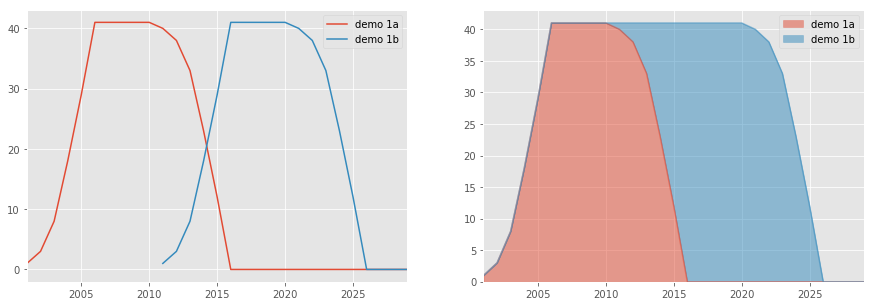

In [14]:
demo_1a = get_forecast(test_profile_no_term, 2001, 2011, 2030, 0, 0, 1, "demo 1a")
demo_1b = get_forecast(test_profile_no_term, 2011, 2021, 2030, 0, 0, 1, "demo 1b")

fig, axs = plt.subplots(1,2)
pd.concat([demo_1a, demo_1b], axis=1).plot(ax=axs[0], figsize=(15,5))
pd.concat([demo_1a, demo_1b], axis=1).plot(ax=axs[1], kind="area", stacked=True, alpha=0.5)

It looks like it's right - identical successive cohorts are the same as a single cohort would be.  Peak spend is sum of profile (NB no point calculating this in sheet, as meaningless for open profiles - this is deliberately closed).

### Another pair, this time with more going on
- cohort and terminal growth (note profile has terminal spend, unlike above)
- second period scaled to reflect cohort growth in first period

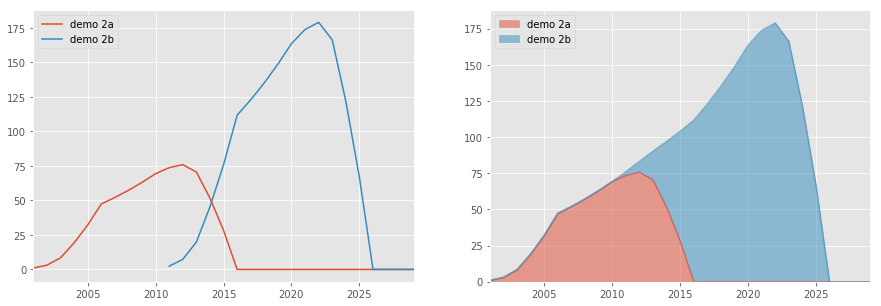

In [15]:
demo_2a = get_forecast(test_profile_no_term, 2001, 2011, 2030, 0.1, -0.1, 1, "demo 2a")
demo_2b = get_forecast(test_profile_no_term, 2011, 2021, 2030, 0.1, -0.1, 1.1**9, "demo 2b")

fig, axs = plt.subplots(1,2)
pd.concat([demo_2a, demo_2b], axis=1).plot(ax=axs[0], figsize=(15,5))
pd.concat([demo_2a, demo_2b], axis=1).plot(ax=axs[1], kind="area", stacked=True, alpha=0.5)

## Creating multiple forecasts - representing annual cohorts

Can automate / parameterise generation of forecasts.  Eg
- Main use of `get_forecast()` is to represent an ongoing or long-running set of spend.  
- But can also use it to model individual annual cohorts.  
- Create a series of annual cohorts in a loop
- NB 20% pa cohort growth applied separately, in the scaling argument  (huge effect)

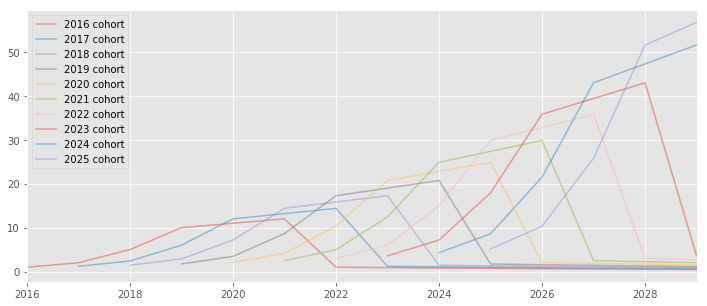

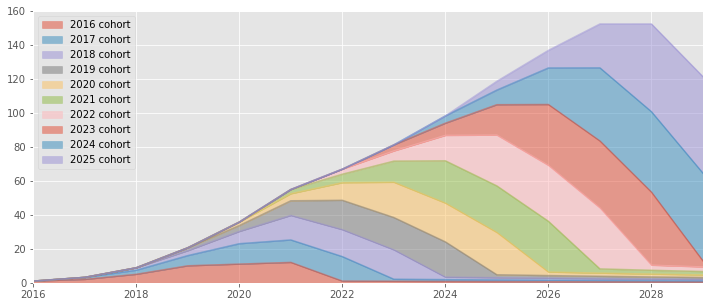

In [16]:
series = []
for i, year in enumerate(range(2016, 2026)):
    series.append(get_forecast(test_profile, year, year+1, 2030, 0, -0.1, 1.2**i, str(year)+" cohort"))

pd.concat(series, axis=1).plot(alpha=0.5, figsize=(12,5))
pd.concat(series, axis=1).plot(kind="area", stacked=True, alpha=0.5, figsize=(12,5))